# Deep Thinking + RAG+CAG Evaluation with 30 Questions (Gemma-27B Judge)

**Author**: Med-Intellagent RAG Team  
**Date**: November 18, 2025  
**Platform**: Google Colab (T4 GPU)  

## Overview
This notebook evaluates **Deep Thinking** and **RAG+CAG** modes using your teammate's comprehensive 30-question test suite. We use **MedGemma-27B-text-it** (4-bit quantized) as the LLM judge to assess responses across 4 key metrics.

## Configuration
- **Judge Model**: google/medgemma-27b-text-it (4-bit quantization)
- **Parser Model**: gpt-4o-mini (for JSON cleanup)
- **Backend**: FastAPI at localhost:8000
- **Modes Evaluated**: Deep Thinking, RAG+CAG
- **Test Questions**: 33
- **Metrics**: Empathy (E), Relevance (R), Faithfulness (F), Helpfulness (H)
- **Scale**: 1-5 (1=Poor, 5=Excellent)

## 1. Install Dependencies


In [1]:
%%capture
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers accelerate bitsandbytes sentencepiece
!pip install openai pandas matplotlib seaborn plotly requests

## 2. Import Libraries

In [2]:
import torch
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from openai import OpenAI
from datetime import datetime
from typing import Dict, List
import re

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA L4


## 3. Configuration

In [42]:
# API Configuration
AWS_BACKEND_URL = "http://54.227.18.183:8000"

# Retrieve OpenAI API key from Colab Secrets
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Model Configuration
GEMMA_MODEL_NAME = "google/medgemma-27b-text-it"
PARSER_MODEL = "gpt-4o-mini"

# Evaluation Modes
MODES = ["deep_thinking", "rag_cag"]

# Output Files
RESULTS_FILE = "deep_thinking_rag_cag_gemma_evaluation_results.json"
COMPARISON_FILE = "deep_thinking_vs_rag_cag_comparison.csv"

## 4. Define 33 Test Questions
These questions come from comprehensive evaluation suite.

In [6]:
# Complete 33-question test suite evaluation
TEST_QUESTIONS = [
    {"patient_id": "25f30c19-e98a-85ea-6de8-f976388d4678", "question": "Give me my blood pressure readings over time"},
    {"patient_id": "0e5401fd-b241-3c84-066e-2b88e5ddafc7", "question": "What are my vitals"},
    {"patient_id": "3de203ff-a5b9-e99a-c705-3927503e2abf", "question": "What has been my maximum weight"},
    {"patient_id": "8c8e1c9a-b310-43c6-33a7-ad11bad21c40", "question": "What has been my weight trend"},
    {"patient_id": "2da86d63-34ae-b887-ddff-8f6f1e6990f1", "question": "What tidings bring'st thou of my latest test results"},
    {"patient_id": "9cbd97ef-2209-9b1c-b6f7-a23a6c081740", "question": "Give me my blood pressure readings over time"},
    {"patient_id": "1a9873c2-1d93-e9d6-4e36-77fdb07fbcb2", "question": "What are my newest test results?"},
    {"patient_id": "e6705c33-7349-8b12-484d-3b1f93227178", "question": "What medications am I currently taking?"},
    {"patient_id": "3f7873ab-0f61-be0c-9af8-f246eec6223a", "question": "What has been my maximum weight"},
    {"patient_id": "9cbd97ef-2209-9b1c-b6f7-a23a6c081740", "question": "What medications am I currently taking?"},
    {"patient_id": "48f06a5e-0d20-3fe6-f5ea-b45bc79e90db", "question": "How screwed up am I?"},
    {"patient_id": "74a4cdcf-7cc0-7658-e1e0-cd1182d5f205", "question": "List all my vital signs"},
    {"patient_id": "006c29d1-d868-3a9e-ceab-31f23e398f45", "question": "Show my vital signs history"},
    {"patient_id": "0c76b28e-5685-0754-12d1-b1a6b79866f7", "question": "Show my vital signs history"},
    {"patient_id": "43e4a5fe-add4-5581-d0ef-80764c313418", "question": "List my active prescriptions"},
    {"patient_id": "575cac8f-bed1-32da-30a6-3a516a78500d", "question": "What are my vitals"},
    {"patient_id": "faec5a04-6c56-4296-9fec-4e218e627a32", "question": "Give me my blood pressure readings over time"},
    {"patient_id": "b9bacf2f-7027-2e05-fa5b-19167071fdde", "question": "What has been my weight trend"},
    {"patient_id": "3270397c-dfa3-6cea-f2ec-be21ade6c52c", "question": "Show my vital signs history"},
    {"patient_id": "3c763653-7fd3-af8a-e65f-79d5bde98d3a", "question": "What tidings bring'st thou of my latest test results"},
    {"patient_id": "349720c1-0627-e77a-1619-bb11b1530e96", "question": "Show my BMI trend"},
    {"patient_id": "0851b7fb-87a8-3edc-1e11-8dcb03824dde", "question": "What medications am I currently taking?"},
    {"patient_id": "782ada1b-32a4-888a-8812-d8de70d6e5d0", "question": "What has been my highest weight"},
    {"patient_id": "103b63c9-9ef8-6d25-771e-2fba661489a1", "question": "Give me my blood pressure readings over time"},
    {"patient_id": "77dfae18-8c8c-0ec2-050c-dd93f3ea1cc2", "question": "What tidings bring'st thou of my latest test results"},
    {"patient_id": "7cad1f7c-cf61-fd24-254f-d02265160c0a", "question": "List my active prescriptions"},
    {"patient_id": "b427e4ea-3a48-207a-bf7d-710f0b574091", "question": "What has been my highest weight"},
    {"patient_id": "0851b7fb-87a8-3edc-1e11-8dcb03824dde", "question": "Show my BMI trend"},
    {"patient_id": "37895f0e-877f-7ea7-aa1b-0b69fcd11385", "question": "What are my vitals"},
    {"patient_id": "43e4a5fe-add4-5581-d0ef-80764c313418", "question": "What is my earliest vital sign"},
    {"patient_id": "c3dae8db-25ee-c40b-c605-600fad411d34", "question": "What has been my weight trend"},
    {"patient_id": "5c68f376-dd2c-1133-a9cf-f023a5d99078", "question": "What has been my weight trend"},
    {"patient_id": "2da86d63-34ae-b887-ddff-8f6f1e6990f1", "question": "List all the medical problems on my record."}
]

print(f"Total test questions: {len(TEST_QUESTIONS)}")
print(f"\nSample questions:")
for i, item in enumerate(TEST_QUESTIONS[:5], 1):
    print(f"{i}. {item['question']} (Patient: {item['patient_id'][:8]}...)")

Total test questions: 33

Sample questions:
1. Give me my blood pressure readings over time (Patient: 25f30c19...)
2. What are my vitals (Patient: 0e5401fd...)
3. What has been my maximum weight (Patient: 3de203ff...)
4. What has been my weight trend (Patient: 8c8e1c9a...)
5. What tidings bring'st thou of my latest test results (Patient: 2da86d63...)


## 5. Load Gemma-27B Model (4-bit Quantized)
Load the judge model with 4-bit quantization to fit in GPU memory.

In [7]:
print("Loading Gemma-27B model with 4-bit quantization...")

# Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(GEMMA_MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    GEMMA_MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

print(f"✅ Model loaded successfully!")
print(f"Model device: {model.device}")
print(f"Model dtype: {model.dtype}")

Loading Gemma-27B model with 4-bit quantization...


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

model-00002-of-00011.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00011.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00006-of-00011.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00011.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00008-of-00011.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00007-of-00011.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00005-of-00011.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00001-of-00011.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00009-of-00011.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00010-of-00011.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00011-of-00011.safetensors:   0%|          | 0.00/4.59G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

✅ Model loaded successfully!
Model device: cuda:0
Model dtype: torch.bfloat16


## 6. Initialize OpenAI Client
For JSON parsing and cleanup with GPT-4o-mini.

In [12]:
# Initialize OpenAI client
openai_client = OpenAI(api_key=OPENAI_API_KEY)

print("✅ OpenAI client initialized for JSON parsing")

✅ OpenAI client initialized for JSON parsing


## 7. Helper Functions

In [37]:
def query_rag_system(patient_id: str, question: str, mode: str) -> Dict:
    """
    Query the AWS FastAPI backend for a specific mode.

    Args:
        patient_id: Patient UUID
        question: User query
        mode: 'deep_thinking' or 'rag_cag'

    Returns:
        Response dict with 'response' and 'response_time'
    """
    # Single endpoint with mode parameter
    endpoint = f"{AWS_BACKEND_URL}/query"

    # Map notebook mode names to API mode names
    mode_map = {
        "deep_thinking": "deep",
        "rag_cag": "rag_cag"
    }

    payload = {
        "patient_id": patient_id,
        "question": question,
        "mode": mode_map[mode]
    }

    try:
        response = requests.post(endpoint, json=payload, timeout=120)
        response.raise_for_status()
        data = response.json()

        return {
            "response": data.get("answer", data.get("response", "No response returned")),
            "response_time": data.get("processing_time", data.get("response_time", 0)),
            "empathy_enhanced": data.get("metadata", {}).get("empathy_enhanced", False) if mode == "rag_cag" else False
        }
    except requests.exceptions.RequestException as e:
        print(f"⚠️ API Request failed: {e}")
        if hasattr(e, 'response') and e.response is not None:
            try:
                error_detail = e.response.json()
                print(f"⚠️ Error details: {error_detail}")
            except:
                print(f"⚠️ Response text: {e.response.text[:200]}")
        return {
            "response": f"Error: {str(e)}",
            "response_time": 0
        }
    except Exception as e:
        print(f"⚠️ Unexpected error: {e}")
        return {
            "response": f"Error: {str(e)}",
            "response_time": 0
        }


def evaluate_with_gemma(question: str, response: str) -> str:
    """
    Evaluate response using Gemma-27B as judge.

    Args:
        question: User's question
        response: System's response to evaluate

    Returns:
        Raw evaluation text from Gemma
    """
    prompt = f"""You are an expert healthcare AI evaluator. Evaluate the following response to a patient's question on these four dimensions (1-5 scale):

**EMPATHY** (1-5): Does the response show compassion and understanding?
- 1: Cold, clinical, no emotional consideration
- 3: Professional but minimal warmth
- 5: Highly compassionate, patient-centered, supportive

**RELEVANCE** (1-5): Does the response directly address the patient's question?
- 1: Off-topic or misses the point
- 3: Partially relevant
- 5: Directly and completely answers the question

**FAITHFULNESS** (1-5): Is the response factually accurate and based on provided data?
- 1: Contains fabricated information
- 3: Mostly accurate with minor issues
- 5: Completely accurate, no hallucinations

**HELPFULNESS** (1-5): Is the response actionable and useful for the patient?
- 1: Not useful
- 3: Somewhat helpful
- 5: Very helpful and actionable

**Patient Question:**
{question}

**System Response:**
{response}

**Instructions:**
1. Evaluate on all four dimensions
2. Provide scores (1-5 integers only)
3. Give brief reasoning

**Return your evaluation in this EXACT JSON format:**
{{
  "empathy": <score>,
  "relevance": <score>,
  "faithfulness": <score>,
  "helpfulness": <score>,
  "reasoning": "Brief explanation of your scores"
}}
"""

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            temperature=0.3,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    response_only = generated_text[len(prompt):].strip()

    return response_only

## 8. Run Evaluation Pipeline
This will take 33 questions × 2 modes.

In [40]:
results = []
total_queries = len(TEST_QUESTIONS) * len(MODES)
current_query = 0
failed_queries = []

print(f"Starting evaluation of {len(TEST_QUESTIONS)} questions across {len(MODES)} modes...\n")
print(f"Total queries: {total_queries}\n")
print("="*80)

for idx, test_item in enumerate(TEST_QUESTIONS, 1):
    patient_id = test_item["patient_id"]
    question = test_item["question"]

    print(f"\n[Question {idx}/{len(TEST_QUESTIONS)}] {question}")
    print(f"Patient: {patient_id[:16]}...")
    print("-" * 80)

    for mode in MODES:
        current_query += 1
        print(f"\n  [{current_query}/{total_queries}] Mode: {mode.upper()}")

        # Step 1: Query RAG system
        print(f"    → Querying FastAPI backend...")
        rag_response = query_rag_system(patient_id, question, mode)
        response_text = rag_response["response"]
        response_time = rag_response["response_time"]

        # Check if this is an error response
        is_error = response_text.startswith("Error:")

        if is_error:
            print(f"    ⚠️ Query failed - {response_text[:100]}...")
            failed_queries.append({
                "question_number": idx,
                "patient_id": patient_id,
                "question": question,
                "mode": mode,
                "error": response_text
            })

            # Store result with error markers
            results.append({
                "question_number": idx,
                "patient_id": patient_id,
                "question": question,
                "mode": mode,
                "response": response_text,
                "response_time": 0,
                "empathy_score": 0,
                "relevance_score": 0,
                "faithfulness_score": 0,
                "helpfulness_score": 0,
                "average_score": 0,
                "reasoning": "Query failed - API error",
                "timestamp": datetime.now().isoformat(),
                "is_error": True
            })
            print(f"    ⚠️ Skipping evaluation for failed query")
            continue

        print(f"    ✓ Response received ({response_time:.2f}s)")
        print(f"    Response preview: {response_text[:100]}...")

        # Step 2: Evaluate with Gemma
        print(f"    → Evaluating with MedGemma-27B...")
        raw_eval = evaluate_with_gemma(question, response_text)
        print(f"    ✓ Raw evaluation complete")

        # Step 3: Parse with GPT-4o-mini
        print(f"    → Parsing JSON with GPT-4o-mini...")
        scores = parse_evaluation_with_gpt4o(raw_eval)
        print(f"    ✓ Scores: E={scores['empathy']}, R={scores['relevance']}, F={scores['faithfulness']}, H={scores['helpfulness']}")

        # Store results
        results.append({
            "question_number": idx,
            "patient_id": patient_id,
            "question": question,
            "mode": mode,
            "response": response_text,
            "response_time": response_time,
            "empathy_score": scores["empathy"],
            "relevance_score": scores["relevance"],
            "faithfulness_score": scores["faithfulness"],
            "helpfulness_score": scores["helpfulness"],
            "average_score": round((scores["empathy"] + scores["relevance"] + scores["faithfulness"] + scores["helpfulness"]) / 4, 2),
            "reasoning": scores.get("reasoning", ""),
            "timestamp": datetime.now().isoformat(),
            "is_error": False
        })

print("\n" + "="*80)
print(f"\n✅ Evaluation complete! Total results: {len(results)}")
print(f"\nResults summary:")
print(f"  Deep Thinking queries: {len([r for r in results if r['mode'] == 'deep_thinking'])}")
print(f"  RAG+CAG queries: {len([r for r in results if r['mode'] == 'rag_cag'])}")
print(f"  Successful queries: {len([r for r in results if not r.get('is_error', False)])}")
print(f"  Failed queries: {len(failed_queries)}")

if failed_queries:
    print(f"\n⚠️ Failed queries breakdown:")
    for fail in failed_queries:
        print(f"  Q{fail['question_number']} - {fail['mode']}: {fail['question'][:50]}...")

Starting evaluation of 33 questions across 2 modes...

Total queries: 66


[Question 1/33] Give me my blood pressure readings over time
Patient: 25f30c19-e98a-85...
--------------------------------------------------------------------------------

  [1/66] Mode: DEEP_THINKING
    → Querying FastAPI backend...
    ✓ Response received (13.59s)
    Response preview: Based on the research findings, there are no blood pressure readings available for you. The LOINC co...
    → Evaluating with MedGemma-27B...
    ✓ Raw evaluation complete
    → Parsing JSON with GPT-4o-mini...
    ✓ Scores: E=1, R=5, F=5, H=1

  [2/66] Mode: RAG_CAG
    → Querying FastAPI backend...
    ✓ Response received (2.42s)
    Response preview: I understand that monitoring your blood pressure is important for your cardiovascular health, and ke...
    → Evaluating with MedGemma-27B...
    ✓ Raw evaluation complete
    → Parsing JSON with GPT-4o-mini...
    ✓ Scores: E=4, R=5, F=5, H=3

[Question 2/33] What are my vitals

## 9. Save Results to JSON

In [43]:
# Save detailed results
with open(RESULTS_FILE, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print(f"✅ Results saved to: {RESULTS_FILE}")
print(f"   File size: {len(json.dumps(results, indent=2)) / 1024:.2f} KB")

✅ Results saved to: deep_thinking_rag_cag_gemma_evaluation_results.json
   File size: 103.96 KB


## 10. Calculate Summary Statistics

In [45]:
# Convert to DataFrame for analysis
df = pd.DataFrame(results)

# Filter out failed queries for statistics
df_success = df[~df.get('is_error', False)].copy()

print(f"\n Total queries: {len(df)}")
print(f"   Successful: {len(df_success)}")
print(f"   Failed: {len(df) - len(df_success)}")

# Calculate statistics by mode
summary = df_success.groupby('mode').agg({
    'empathy_score': ['mean', 'std'],
    'relevance_score': ['mean', 'std'],
    'faithfulness_score': ['mean', 'std'],
    'helpfulness_score': ['mean', 'std'],
    'average_score': ['mean', 'std'],
    'response_time': ['mean', 'std']
}).round(3)

print("\n" + "="*80)
print("SUMMARY STATISTICS BY MODE")
print("="*80)
print(summary)

# Overall averages
print("\n" + "="*80)
print("OVERALL AVERAGES")
print("="*80)
for mode in MODES:
    mode_data = df_success[df_success['mode'] == mode]
    if len(mode_data) > 0:
        avg_score = mode_data['average_score'].mean()
        success_rate = len(mode_data) / len(df[df['mode'] == mode]) * 100
        print(f"{mode.upper():20s}: {avg_score:.2f} / 5.00 ({success_rate:.1f}% success rate)")
    else:
        print(f"{mode.upper():20s}: No successful queries")

# Winner
print("\n" + "="*80)
if len(df_success) > 0:
    best_mode = df_success.groupby('mode')['average_score'].mean().idxmax()
    best_score = df_success.groupby('mode')['average_score'].mean().max()
    print(f" BEST PERFORMER: {best_mode.upper()} ({best_score:.2f})")
else:
    print(f"⚠️ No successful queries to compare")
print("="*80)


 Total queries: 66
   Successful: 65
   Failed: 1

SUMMARY STATISTICS BY MODE
              empathy_score        relevance_score        faithfulness_score  \
                       mean    std            mean    std               mean   
mode                                                                           
deep_thinking         1.000  0.000           4.875  0.492              5.000   
rag_cag               3.818  0.465           4.788  0.696              4.939   

                     helpfulness_score       average_score         \
                 std              mean   std          mean    std   
mode                                                                
deep_thinking  0.000             3.688  1.23         3.641  0.347   
rag_cag        0.348             3.879  0.82         4.356  0.410   

              response_time          
                       mean     std  
mode                                 
deep_thinking        34.883  21.420  
rag_cag               

## 11. Create Comparison DataFrame

In [55]:
# Pivot for side-by-side comparison
comparison_data = []

for idx in range(1, len(TEST_QUESTIONS) + 1):
    question_results = df[df['question_number'] == idx]

    deep_thinking = question_results[question_results['mode'] == 'deep_thinking'].iloc[0]
    rag_cag = question_results[question_results['mode'] == 'rag_cag'].iloc[0]

    # Determine winner
    dt_error = deep_thinking.get('is_error', False)
    rc_error = rag_cag.get('is_error', False)

    if dt_error and rc_error:
        winner = 'Both Failed'
    elif dt_error:
        winner = 'RAG+CAG (DT Failed)'
    elif rc_error:
        winner = 'Deep Thinking (RC Failed)'
    elif deep_thinking['average_score'] > rag_cag['average_score']:
        winner = 'Deep Thinking'
    elif rag_cag['average_score'] > deep_thinking['average_score']:
        winner = 'RAG+CAG'
    else:
        winner = 'Tie'

    comparison_data.append({
        'question_number': idx,
        'patient_id': deep_thinking['patient_id'],
        'question': deep_thinking['question'],
        'dt_empathy': deep_thinking['empathy_score'],
        'dt_relevance': deep_thinking['relevance_score'],
        'dt_faithfulness': deep_thinking['faithfulness_score'],
        'dt_helpfulness': deep_thinking['helpfulness_score'],
        'dt_average': deep_thinking['average_score'],
        'dt_response_time': deep_thinking['response_time'],
        'dt_is_error': dt_error,
        'rc_empathy': rag_cag['empathy_score'],
        'rc_relevance': rag_cag['relevance_score'],
        'rc_faithfulness': rag_cag['faithfulness_score'],
        'rc_helpfulness': rag_cag['helpfulness_score'],
        'rc_average': rag_cag['average_score'],
        'rc_response_time': rag_cag['response_time'],
        'rc_is_error': rc_error,
        'winner': winner
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv(COMPARISON_FILE, index=False)

print(f"✅ Comparison saved to: {COMPARISON_FILE}")
print(f"\nWin/Loss Summary:")
print(comparison_df['winner'].value_counts())

✅ Comparison saved to: deep_thinking_vs_rag_cag_comparison.csv

Win/Loss Summary:
winner
RAG+CAG                30
Deep Thinking           2
RAG+CAG (DT Failed)     1
Name: count, dtype: int64


## 12. Visualization: Mode Comparison

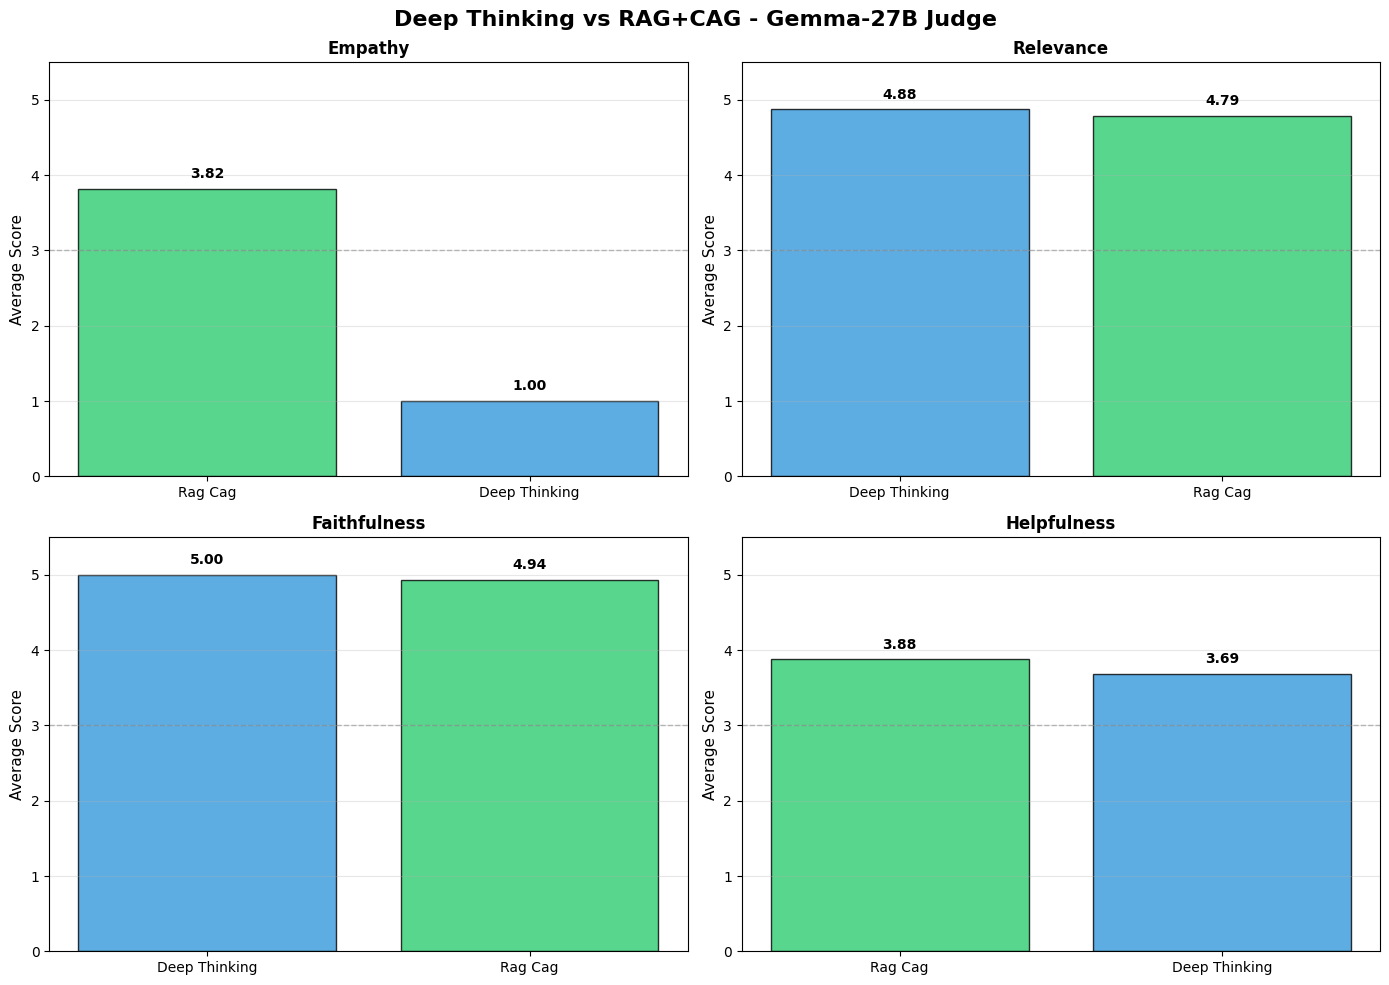

✅ Comparison chart saved: deep_thinking_vs_rag_cag_gemma_comparison.png


In [56]:
# Bar chart comparing average scores
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Deep Thinking vs RAG+CAG - Gemma-27B Judge', fontsize=16, fontweight='bold')

metrics = ['empathy_score', 'relevance_score', 'faithfulness_score', 'helpfulness_score']
titles = ['Empathy', 'Relevance', 'Faithfulness', 'Helpfulness']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]

    mode_scores = df_success.groupby('mode')[metric].mean().sort_values(ascending=False)
    colors = ['#2ecc71' if mode == 'rag_cag' else '#3498db' for mode in mode_scores.index]

    bars = ax.bar(range(len(mode_scores)), mode_scores.values, color=colors, alpha=0.8, edgecolor='black')
    ax.set_xticks(range(len(mode_scores)))
    ax.set_xticklabels([m.replace('_', ' ').title() for m in mode_scores.index], rotation=0)
    ax.set_ylabel('Average Score', fontsize=11)
    ax.set_title(f'{title}', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 5.5)
    ax.axhline(y=3, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Baseline (3.0)')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('deep_thinking_vs_rag_cag_gemma_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comparison chart saved: deep_thinking_vs_rag_cag_gemma_comparison.png")

## 13. Visualization: Overall Average Scores

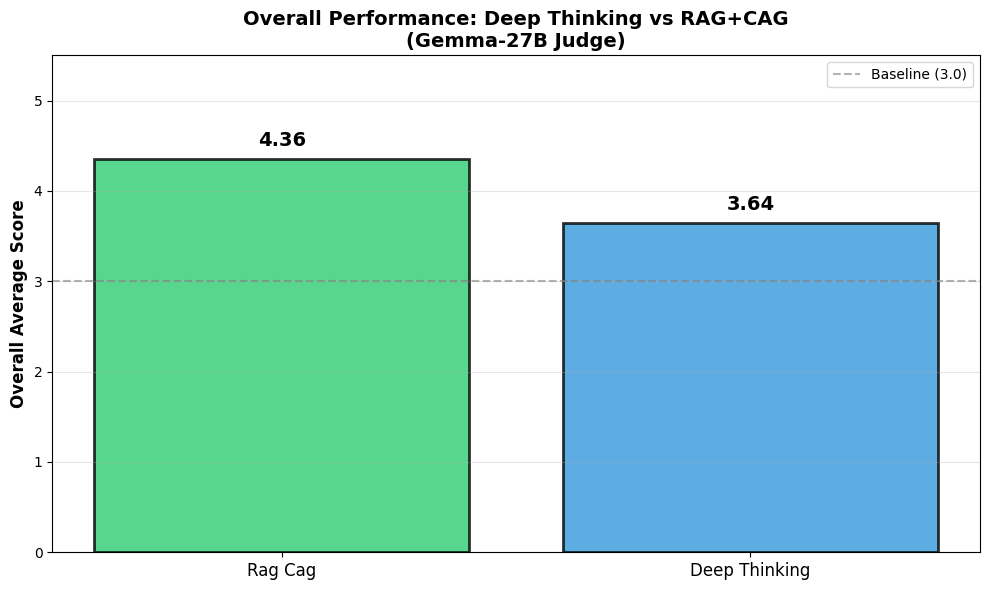

✅ Overall chart saved: deep_thinking_vs_rag_cag_gemma_overall.png


In [50]:
# Overall average comparison
plt.figure(figsize=(10, 6))

mode_averages = df_success.groupby('mode')['average_score'].mean().sort_values(ascending=False)
colors = ['#2ecc71' if mode == 'rag_cag' else '#3498db' for mode in mode_averages.index]

bars = plt.bar(range(len(mode_averages)), mode_averages.values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
plt.xticks(range(len(mode_averages)), [m.replace('_', ' ').title() for m in mode_averages.index], fontsize=12)
plt.ylabel('Overall Average Score', fontsize=12, fontweight='bold')
plt.title('Overall Performance: Deep Thinking vs RAG+CAG\n(Gemma-27B Judge)', fontsize=14, fontweight='bold')
plt.ylim(0, 5.5)
plt.axhline(y=3, color='gray', linestyle='--', linewidth=1.5, alpha=0.6, label='Baseline (3.0)')
plt.grid(axis='y', alpha=0.3)
plt.legend()

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('deep_thinking_vs_rag_cag_gemma_overall.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Overall chart saved: deep_thinking_vs_rag_cag_gemma_overall.png")

## 14. Visualization: Response Time Analysis

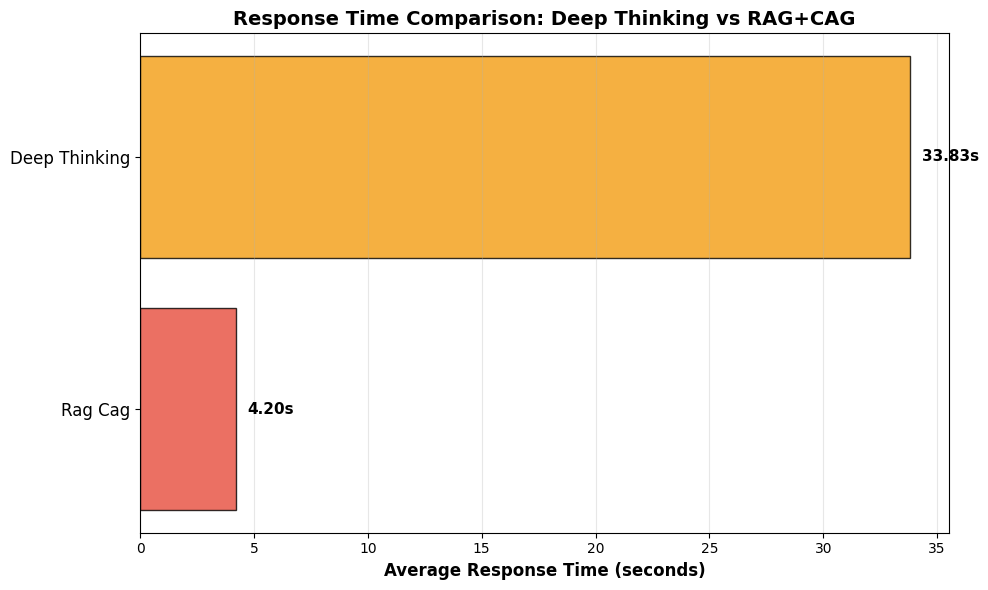

✅ Response time chart saved: deep_thinking_vs_rag_cag_response_times.png


In [51]:
# Response time comparison
plt.figure(figsize=(10, 6))

mode_times = df.groupby('mode')['response_time'].mean().sort_values()
colors = ['#e74c3c', '#f39c12']

bars = plt.barh(range(len(mode_times)), mode_times.values, color=colors, alpha=0.8, edgecolor='black')
plt.yticks(range(len(mode_times)), [m.replace('_', ' ').title() for m in mode_times.index], fontsize=12)
plt.xlabel('Average Response Time (seconds)', fontsize=12, fontweight='bold')
plt.title('Response Time Comparison: Deep Thinking vs RAG+CAG', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
            f'{width:.2f}s', ha='left', va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('deep_thinking_vs_rag_cag_response_times.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Response time chart saved: deep_thinking_vs_rag_cag_response_times.png")

## 15. Question-Level Heatmap

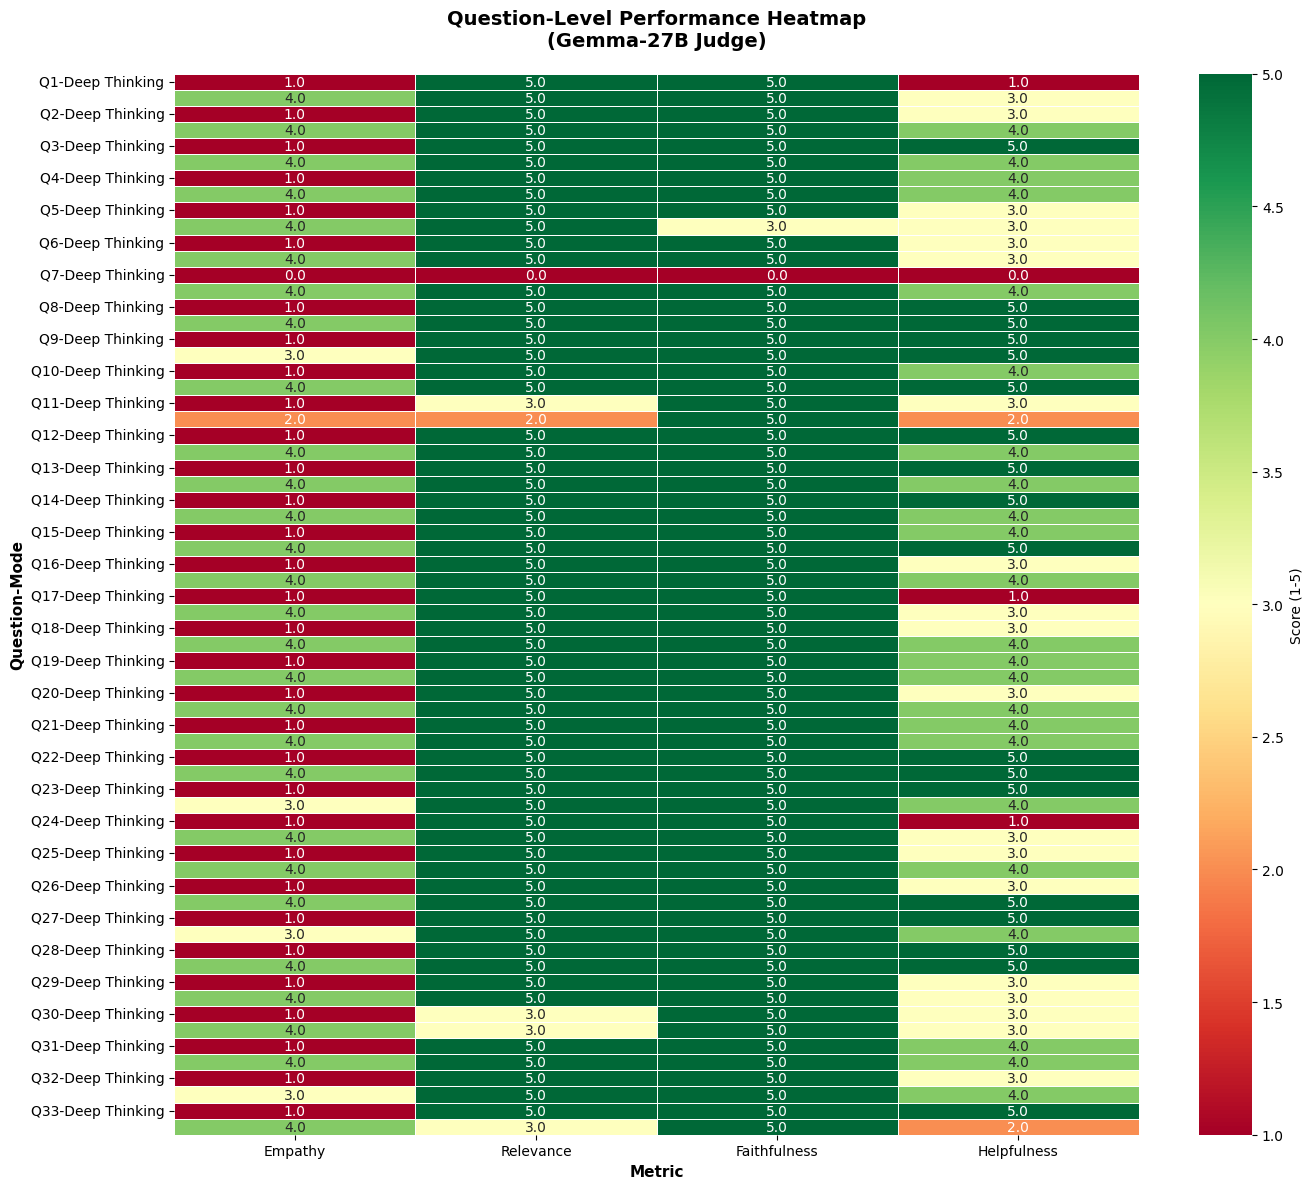

✅ Heatmap saved: deep_thinking_vs_rag_cag_heatmap.png


In [52]:
# Create heatmap of scores per question
plt.figure(figsize=(14, 12))

# Prepare data for heatmap
heatmap_data = []
for idx in range(1, len(TEST_QUESTIONS) + 1):
    question_results = df[df['question_number'] == idx]
    for mode in MODES:
        mode_result = question_results[question_results['mode'] == mode].iloc[0]
        heatmap_data.append([
            mode_result['empathy_score'],
            mode_result['relevance_score'],
            mode_result['faithfulness_score'],
            mode_result['helpfulness_score']
        ])

heatmap_array = pd.DataFrame(heatmap_data,
                              index=[f"Q{i//2+1}-{MODES[i%2].replace('_', ' ').title()}" for i in range(len(heatmap_data))],
                              columns=['Empathy', 'Relevance', 'Faithfulness', 'Helpfulness'])

sns.heatmap(heatmap_array, annot=True, fmt='.1f', cmap='RdYlGn', vmin=1, vmax=5,
            cbar_kws={'label': 'Score (1-5)'}, linewidths=0.5)
plt.title('Question-Level Performance Heatmap\n(Gemma-27B Judge)', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Question-Mode', fontsize=11, fontweight='bold')
plt.xlabel('Metric', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('deep_thinking_vs_rag_cag_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Heatmap saved: deep_thinking_vs_rag_cag_heatmap.png")

## 16. Final Summary Report

In [53]:
print("\n" + "="*80)
print("FINAL EVALUATION SUMMARY")
print("="*80)
print(f"\n **Evaluation Configuration**")
print(f"   Judge Model: {GEMMA_MODEL_NAME}")
print(f"   Parser Model: {PARSER_MODEL}")
print(f"   Test Questions: {len(TEST_QUESTIONS)}")
print(f"   Modes Evaluated: {', '.join([m.replace('_', ' ').title() for m in MODES])}")
print(f"   Total Evaluations: {len(results)}")

print(f"\n **Performance Ranking**")
mode_rankings = df.groupby('mode')['average_score'].mean().sort_values(ascending=False)
for rank, (mode, score) in enumerate(mode_rankings.items(), 1):
    print(f"   {rank}. {mode.replace('_', ' ').title():20s} - {score:.2f} / 5.00")

print(f"\n **Detailed Metrics (Mean ± Std)**")
for mode in MODES:
    mode_data = df[df['mode'] == mode]
    print(f"\n   {mode.replace('_', ' ').upper()}:")
    print(f"      Empathy:      {mode_data['empathy_score'].mean():.2f} ± {mode_data['empathy_score'].std():.2f}")
    print(f"      Relevance:    {mode_data['relevance_score'].mean():.2f} ± {mode_data['relevance_score'].std():.2f}")
    print(f"      Faithfulness: {mode_data['faithfulness_score'].mean():.2f} ± {mode_data['faithfulness_score'].std():.2f}")
    print(f"      Helpfulness:  {mode_data['helpfulness_score'].mean():.2f} ± {mode_data['helpfulness_score'].std():.2f}")
    print(f"      Response Time: {mode_data['response_time'].mean():.2f}s ± {mode_data['response_time'].std():.2f}s")

print(f"\n **Win/Loss Record**")
win_counts = comparison_df['winner'].value_counts()
for mode, count in win_counts.items():
    percentage = (count / len(comparison_df)) * 100
    print(f"   {mode:20s}: {count:2d} / {len(comparison_df)} ({percentage:.1f}%)")

print(f"\n **Output Files**")
print(f"   Results JSON: {RESULTS_FILE}")
print(f"   Comparison CSV: {COMPARISON_FILE}")
print(f"   Visualizations: 4 PNG files")

print("\n" + "="*80)
print("✅ EVALUATION COMPLETE!")
print("="*80)


FINAL EVALUATION SUMMARY

 **Evaluation Configuration**
   Judge Model: google/medgemma-27b-text-it
   Parser Model: gpt-4o-mini
   Test Questions: 33
   Modes Evaluated: Deep Thinking, Rag Cag
   Total Evaluations: 66

 **Performance Ranking**
   1. Rag Cag              - 4.36 / 5.00
   2. Deep Thinking        - 3.53 / 5.00

 **Detailed Metrics (Mean ± Std)**

   DEEP THINKING:
      Empathy:      0.97 ± 0.17
      Relevance:    4.73 ± 0.98
      Faithfulness: 4.85 ± 0.87
      Helpfulness:  3.58 ± 1.37
      Response Time: 33.83s ± 21.94s

   RAG CAG:
      Empathy:      3.82 ± 0.46
      Relevance:    4.79 ± 0.70
      Faithfulness: 4.94 ± 0.35
      Helpfulness:  3.88 ± 0.82
      Response Time: 4.20s ± 2.81s

 **Win/Loss Record**
   RAG+CAG             : 30 / 33 (90.9%)
   Deep Thinking       :  2 / 33 (6.1%)
   RAG+CAG (DT Failed) :  1 / 33 (3.0%)

 **Output Files**
   Results JSON: deep_thinking_rag_cag_gemma_evaluation_results.json
   Comparison CSV: deep_thinking_vs_rag_cag_c

### Download Generated Files Programmatically

In [54]:
from google.colab import files

output_files = [
    "deep_thinking_rag_cag_gemma_evaluation_results.json",
    "deep_thinking_vs_rag_cag_comparison.csv",
    "deep_thinking_vs_rag_cag_gemma_comparison.png",
    "deep_thinking_vs_rag_cag_gemma_overall.png",
    "deep_thinking_vs_rag_cag_response_times.png",
    "deep_thinking_vs_rag_cag_heatmap.png"
]

for filename in output_files:
    try:
        files.download(filename)
        print(f"Downloaded: {filename}")
    except FileNotFoundError:
        print(f"File not found: {filename}. It might not have been generated yet or the name is incorrect.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: deep_thinking_rag_cag_gemma_evaluation_results.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: deep_thinking_vs_rag_cag_comparison.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: deep_thinking_vs_rag_cag_gemma_comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: deep_thinking_vs_rag_cag_gemma_overall.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: deep_thinking_vs_rag_cag_response_times.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: deep_thinking_vs_rag_cag_heatmap.png
